<h1>Tracking the urgency of COVID19-communication over time</h1>

<h3> How? </h3>
We use four different datasets: official government communication, The Guardian, The Telegraph, and Twitter.

Chosen periods of time (clustered around peaks in ICU occupancy, and the absolute low with regard to ICU occupancy): \
(1) First peak: April 12, 2020 [09.04.2020 - 15.04.2020] \
(2) Absolute low: August 28, 2020 [25.08.2020 - 31.08.2020] \
(3) Second (absolute) peak: January 24, 20201 [21.01.2021 - 27.01.2021]

<h3>Get Government Communication</h3>
We use Web Scraper to grab official Government Communication (from gov.uk) filtering by topic 'Coronavirus' and the time periods. \\

The resulting excel sheets can be found here:\
https://sciencespofr-my.sharepoint.com/personal/alexander_elg_sciencespo_fr/_layouts/15/guestaccess.aspx?guestaccesstoken=OWpRapvufQKSs0mCuwyL%2F0k%2Fb8dXGwgTXUDmkBwARDs%3D&folderid=2_0d75e4121abe34d2abcc5fd23b1eed5a6&rev=1&e=uviguj

In [2]:
import pandas as pd
import json
import spacy
import requests 
import random

<h4>Data scraping Official Statements</h4>

In [2]:
#we need openpyxl to open excel sheets
%pip install 'openpyxl'

Note: you may need to restart the kernel to use updated packages.


In [3]:
import openpyxl
officialTP1 = pd.read_excel("./govtp11.xlsx")
officialTP2 = pd.read_excel("./govtp2.xlsx")
officialTP3 = pd.read_excel("./govtp3_1.xlsx")

We define a function to extract data from excel sheets into Python dictionaries, where the article title is stored as Key, and its text as Value

In [4]:
def dictget(df, key, value):
    titlel = df[key].tolist()
    textl = df[value].tolist()
    results = {}
    for i in range(len(titlel)):
        results[titlel[i]]=textl[i]
    return results

In [5]:
# get dictionary for TP1
of1_dic = dictget(officialTP1, 'arttitle', 'combinedarttex')

In [6]:
# get dictionary for TP2
of2_dic = dictget(officialTP2, 'arttitle', 'combinedarttex')

In [7]:
# get dictionary for TP3
of3_dic = dictget(officialTP3, 'arttitle', 'combinedarttex')

<h3>Get text from The Guardian</h3>
The Guardian provides a comprehensive API that gives users access to everything except pictures and possible audio clips. We can therefore scrape every single word on specific topics during our chosen time periods.

<h4>Data scraping The Guardian</h4>

We define a function that uses a modified version of the NYT API function to scrape full article texts from The Guardian using its API

In [17]:
import json
import spacy
import requests 
import numpy as np
import pandas as pd
import warnings

def searchguard(api_key,tag,q,begin_date,end_date, pages):
    
    qs = q.split()
    """Returns a list of articles for a given query
    
    Parameters:
    api_key (str): your Guardian api key
    keyword (str): a keyword by which you want to filter the articles
    begin_date (str): a begin date in the format "YYYYMMDD"
    end_date (str): a begin date in the format "YYYYMMDD"
    pages (int): how many pages to run through (you get 10 articles per page)
    tag (str): the specific tag you're searching for (structured like {main topic}/{subtopic})
    
    
    It should be able to process multiple keywords
    Returns:
    docs (list): a list of articles as dictionaries
    """
    st = ""
    docs = []
    if len(qs) > 1:
        for w in qs:
            st += w + "%20OR%20"
    else:
        st = qs[0]
    for i in range(pages):
        #pagination starts at 1 hence
        i = i+1
        api = f"https://content.guardianapis.com/search?page={i}&q={st}&tag={tag}&from-date={begin_date}&to-date={end_date}&show-fields=bodyText&api-key={api_key}"   
        response = requests.get(api)
        data = response.json()
        docs.append(data)  
    return docs

def results(l):
    #every list index contains a dictionary. iterate through them
    #and initialise dictionary to return   
    results={}
    for q in l:
        #this layer contains a list of dictionaries. iterate through them
        for w in q.values():
            #this **should** create a list with -- you know it -- more dictionaries
            res = w['results']
            for k in res:
                #iterate through values in this final nested dictionary
                for v in k.keys():
                    #and create a new dictionary into which to put the articles
                    results[k['webTitle']]=k['fields']['bodyText']             
    return results

api_key = "55f57dcd-e04e-4905-8734-e598ff187eaf"
begin_date_TP1 = "2020-04-09"
end_date_TP1 = "2020-04-15"
begin_date_TP2 = "2020-08-25"
end_date_TP2 = "2020-08-31"
begin_date_TP3 = "2021-01-21"
end_date_TP3 = "2021-01-27"
tag = "politics/health"
q = 'covid'

Running the code below creates a dictionary with headlines as Keys and body text as Values. We can change tags and search query whenever through changing tag and q.\
It takes as arguments api_key, tag, q, begin date, end date, and the amound of pages (1 page returns 10 articles)

In [18]:
#TP1
p = 3
gtp1_dic = (results(searchguard(api_key, tag, q, begin_date_TP1, end_date_TP1, p)))

In [19]:
print(len(gtp1_dic.keys()))

23


In [20]:
#TP2
p = 2 #query only returns 16 articles, hence the lower p
gtp2_dic = (results(searchguard(api_key, tag, q, begin_date_TP2, end_date_TP2, p)))

In [21]:
#TP3
p = 3
gtp3_dic = (results(searchguard(api_key, tag, q, begin_date_TP3, end_date_TP3, p)))

<h3> Get text from The Telegraph</h3>
The following snippets of code use Mediacloud and Minet to extract articles from The Telegraph.

<h4>Data scraping The Telegraph</h4>

Supporting Mediacloud code:

In [22]:
!pip install python-dotenv
!pip install mediacloud

from dotenv import load_dotenv
load_dotenv()  # load config from .env file

import os, mediacloud.api
# Read your personal API key from that .env file
MC_API_KEY='a514f7d36dcb83bd196d4c2786500c8ef158f76af306e464afad27749de31d29'
my_mc_api_key = os.getenv(MC_API_KEY)
# A convention we use is to name your api client `mc`
mc = mediacloud.api.MediaCloud(MC_API_KEY)
mediacloud.__version__

# make sure your connection and API key work by asking for the high-level system statistics
mc.stats()

{'active_crawled_feeds': 162441,
 'active_crawled_media': 58074,
 'daily_downloads': 1131439,
 'daily_stories': 636775,
 'mediacloud_stats_id': 10,
 'stats_date': '2022-04-03',
 'total_downloads': 0,
 'total_sentences': 0,
 'total_stories': 0}

In [23]:
# Telegraph media_id: '1750'
matching_sources = mc.mediaList(name_like='telegraph', sort='num_stories')

We define a number of functions to extract article text from The Telegraph. Headlines are stored as Keys and text is stored as Values.

In [24]:
#!pip install newspaper3k
from tqdm import tqdm
from newspaper import Article
import datetime

def url_to_text(url):
    article = Article(url)
    article.download()
    article.parse()
    text = article.text
    return text

#since everything else is provided as a dictionary, let's do it here too
def teldic (l):
    result = {}
    for i in range(len(l)):
        result[i]=l[i]
    return result

query = "((UK OR England) AND (quarantine OR lockdown OR covid19 OR coronavirus OR corona OR pandemic))"

#generic function to retrieve articles from the telegraph
def searchtel(begindate, enddate, query):
    fetch_size = 100000
    stories = []
    last_processed_stories_id = 0
    while len(stories) < 2000:
        fetched_stories = mc.storyList(solr_query= f"{query} AND media_id:1750", # Telegraph media_id=1750
                                   solr_filter=mc.dates_as_query_clause(begindate, enddate),
                                   last_processed_stories_id=last_processed_stories_id, rows= fetch_size)
        stories.extend(fetched_stories)
        if len( fetched_stories) < fetch_size:
            break
        last_processed_stories_id = stories[-1]['processed_stories_TP1_id']

    print(f'Number articles: {len(stories)}')

    has_no_text=0
    for story in stories:
        if story['word_count'] is None:
            has_no_text+=1

    url_list=list()
    for story in stories:
        url_list.append(story['url'])
    
    url2text = dict.fromkeys(url_list)
    for url in tqdm(url_list):
        try:
            text = url_to_text(url)
            url2text[url] = text
        except :
            url2text[url] = 'Error'

    telegraph=[x for x in list(url2text.values()) if x!='Error']

    toreturn = teldic(telegraph)

    return toreturn

We store text in dictionaries:

In [25]:
#TP1
begin_TP1 = datetime.date(2020,4,9)
end_TP1=datetime.date(2020,4,15)
tetp1_dic = searchtel(begin_TP1, end_TP1, query)

Number articles: 129


100%|██████████| 129/129 [02:20<00:00,  1.09s/it]


In [52]:
#TP2
begin_TP2 = datetime.date(2020,8,25)
end_TP2=datetime.date(2020,8,31)
tetp2_dic = searchtel(begin_TP2, end_TP2, query)

Number articles: 63


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


In [53]:
#TP3
begin_TP3=datetime.date(2021,1,21)
end_TP3=datetime.date(2021,1,27)
tetp3_dic = searchtel(begin_TP3, end_TP3, query)

Number articles: 106


100%|██████████| 106/106 [02:07<00:00,  1.20s/it]


<h3>Get data from Twitter</h3>
Since the standard Twitter API only allows to retrieve of tweets from the past week, we may recur to scraping in order to collect tweets that were published earlier than this. The downside of this method is that it is a bit slower and that it does not allow us to retrieve any retweet information.
Using minet, we can scrape tweets from the public API using an advanced search query.

 Twitter API (en cas ou)
  API KEY gG7WbcCh0p3HtpqpxKevtqBKg
                API KEY SECRET mG0H6QLLu6iZ67WvBSMcXjjipFInJNo9bccQuQjFwK9fxzt7JF
                token 614583941-E3cku2CxtBB00XhzKNHhyx8ShBHjYG93DAAVg7AL
                token secret BeYVe9lslMHZ2yvdF9FKPDJv4d0hCiRZ18ufG9JDMRly1

<h4>Scraping from Twitter</h4>

In [ ]:
!pip install minet

In [ ]:
!minet tw scrape

usage: minet twitter scrape [-h] [--rcfile RCFILE] [--include-refs] [-l LIMIT]
                            [-o OUTPUT] [--query-template QUERY_TEMPLATE]
                            [-s SELECT]
                            {tweets,users} query [file]
minet twitter scrape: error: the following arguments are required: items, query, file


In [27]:
#generic dictionary making function for tweets
def tweetdic(df):
    indl = df.index
    textl = df['text'].tolist()
    dic_to_return = {}
    for i in range(len(indl)):
        dic_to_return[indl[i]]=textl[i]
    return dic_to_return

The snippets of code below download Twitter data into csvs, and extracts data from there into dictionaries.

Time Period 1 (TP1)

In [ ]:
# Search Query to filter for tweets between in the given Time Periods (TP) --> The search query is identical for all three time periods
# The search has been limited to 1000 tweets per time period due to computer processing restrictions
!minet tw scrape tweets "((UK OR England) AND (quarantine OR lockdown OR covid19 OR coronavirus OR corona OR pandemic)) lang:en until:2020-04-15 since:2020-04-09" --limit 1000 > tweets_TP1.csv

Searching for "((UK OR England) AND (quarantine OR lockdown OR covid19 OR coronavirus OR corona OR pandemic)) lang:en until:2020-04-15 since:2020-04-09"


In [28]:
df_TP1_Twitter = pd.read_csv("./tweets_TP1.csv")
# df_TP1_Twitter to see the df

In [29]:
# clean data and extract overview
df_TP1_Twitter = df_TP1_Twitter[df_TP1_Twitter['text'].notna()]


In [30]:
#putting relevant information into dictionary: index is key, text is value

twtp1_dic = tweetdic(df_TP1_Twitter)

Time Period 2 (TP2)

In [26]:
!minet tw scrape tweets "((UK OR England) AND (quarantine OR lockdown OR covid19 OR coronavirus OR corona OR pandemic)) lang:en until:2020-08-31 since:2020-08-25" --limit 1000 > tweets_TP2.csv

Searching for "((UK OR England) AND (quarantine OR lockdown OR covid19 OR coronavirus OR corona OR pandemic)) lang:en until:2020-08-31 since:2020-08-25"


In [31]:
df_TP2_Twitter = pd.read_csv("./tweets_TP2.csv")

In [32]:
# clean data and extract overview
df_TP2_Twitter = df_TP2_Twitter[df_TP2_Twitter['text'].notna()]

In [33]:
# creating dictionary from CSV - dictionary will include index and text per tweet
twtp2_dic = tweetdic(df_TP2_Twitter)

Time Period 3 (TP3)

In [30]:
!minet tw scrape tweets "((UK OR England) AND (quarantine OR lockdown OR covid19 OR coronavirus OR corona OR pandemic)) lang:en until:2021-01-27 since:2021-01-21" --limit 1000 > tweets_TP3.csv

Searching for "((UK OR England) AND (quarantine OR lockdown OR covid19 OR coronavirus OR corona OR pandemic)) lang:en until:2021-01-27 since:2021-01-21"


In [34]:
df_TP3_Twitter = pd.read_csv("./tweets_TP3.csv")

In [35]:
# clean data and extract overview
df_TP3_Twitter = df_TP3_Twitter[df_TP3_Twitter['text'].notna()]

In [36]:
twtp3_dic = tweetdic(df_TP3_Twitter)

<h1>This is the section in which we extract adjectives and check for similarity</h1>

In [62]:
#!pip install gensim
#!pip install pandas

import gensim
import numpy as np
import gensim.downloader as api
import matplotlib.pyplot as plt
from numpy.linalg import norm
from collections import Counter
import pandas as pd

nlp = spacy.load("en_core_web_sm")

In [38]:
from statistics import mean

Choose pre-trained model and load it:

In [39]:
model = api.load("word2vec-google-news-300")

Define an original list of words that signify urgency:

In [41]:
uwords = ['critical','troubling','problematic','essential','troublesome','pivotal','serious','worrisome','extreme', 'major','significant','dangerous', 'vital', 'crucial', 'important', 'critical', 'urgent', 'risky', 'severe', 'worrying', 'stringent', 'unprecedented']

We can use most_similar to find other words we may want to include in the original list:

In [38]:
model.most_similar(uwords)

[('vitally_important', 0.6015803813934326),
 ('difficult', 0.584695041179657),
 ('key', 0.5815590023994446),
 ('problematical', 0.5756705403327942),
 ('perilous', 0.5537168979644775),
 ('distressing', 0.5491712689399719),
 ('alarming', 0.5393417477607727),
 ('criticial', 0.5372740626335144),
 ('imperative', 0.5331820249557495),
 ('paramount_importance', 0.5308540463447571)]

We now create an average vector of the vectors of the words in our original list. The length of this vector is the number of dimensions, it changes depending on which model we use:

In [42]:
urgvectors = []
for i in range(len(uwords)):
    urgvectors.append(model.get_vector(uwords[i]))

avgs = np.mean(urgvectors, axis=0)
print(avgs)
len(avgs)

[ 0.04076143 -0.00715915  0.00234569  0.01536976 -0.12590651  0.02655307
  0.13603903 -0.0169546   0.10722455  0.03749223 -0.01869202 -0.19133967
  0.08565313  0.08389976 -0.1246005   0.05567932  0.02083657 -0.03671542
 -0.11597789  0.06311729  0.00596619 -0.05841897 -0.18485884  0.11116583
  0.02227783  0.01205028 -0.01814686 -0.04411732  0.07609281  0.02089899
  0.10677476  0.03342091  0.17465487 -0.05876576 -0.01433875 -0.12278886
 -0.04521041  0.04359921  0.09679066 -0.03764343  0.13405539 -0.06935258
  0.09196889  0.00281178 -0.10443115 -0.00779585  0.00076849  0.03462011
 -0.0407538  -0.08149303  0.02818662  0.06545743 -0.11571364 -0.02323775
 -0.04301002  0.07522999  0.05697701 -0.11362665  0.08640636 -0.05238984
 -0.15350653  0.16264413 -0.13078724 -0.09883256  0.09253207  0.02524636
 -0.0112915   0.13699064 -0.13093151 -0.10864951 -0.06927698 -0.07520641
  0.08291037 -0.0200667  -0.12928079 -0.03333421  0.07068114  0.21843928
  0.02304354  0.2565585  -0.03482888  0.0505593   0

300

To check if the average vector makes any sense, we can find the words most similar to this vector, and see if we think they are good markers for urgency:

In [40]:
model.similar_by_vector(avgs)

[('important', 0.7393355965614319),
 ('critical', 0.7357078790664673),
 ('crucial', 0.719694972038269),
 ('problematic', 0.7039634585380554),
 ('worrisome', 0.686864972114563),
 ('troubling', 0.6845951080322266),
 ('vital', 0.6648507714271545),
 ('troublesome', 0.6420120000839233),
 ('dangerous', 0.6281273365020752),
 ('significant', 0.6221376657485962)]

We now define cosine similarity as a function to then compare word vectors from words in our sources to the average vector:

In [43]:
def cosine_similarity(vector1,vector2):
    result = np.dot(vector1, vector2)/(norm(vector1)*norm(vector2))
    return result

Now, we can see that this function allows us to find measures of similarity to our average "urgency" vector:

In [44]:
words = ["challenging","serious","urgent","fingers", "teeth", "happy", "mouse"]
projections = []
for word in words:
    wordvector = model.get_vector(word)
    projections.append(cosine_similarity(wordvector,avgs))
print(projections)

[0.4787601, 0.61980236, 0.52486134, 0.0923162, 0.1188931, 0.24206077, 0.10215004]


Now we define a function to mark words as "urgency signifiers", depending on cosine similarity:

In [45]:
def urgent_marker(word, threshold):
    result = cosine_similarity(model.get_vector(word),avgs)
    if result < threshold:
        result = 0
    else:
        result = 1
    return result

We can check this with some examples:

In [44]:
urgent_marker("interesting", 0.6)

urgent_marker("decisive", 0.6)

0

This is the code that should work directly on the article

In [46]:
def urgprop(dicc, threshold):
    urgent_lst = []
    count = 0
    means_lst=[]
    wl = []
    wl2 = []
    negcount = 0
    countdic1 = {}
    

    for i in range(len(dicc.values())):  
        doc = nlp(list(dicc.values())[i])
        countdic1[list(dicc.values())[i]] = doc
        count += 1
        for token in doc:
            if token.pos_ == "ADJ":
                try:
                    urgent_lst.append(urgent_marker(f"{token.text.lower()}", threshold))
                    #print(f"{token.text.lower()}",urgent_marker(f"{token.text.lower()}", 0.5)) #this line is just for checking
                except:
                    continue
        if len(urgent_lst)!= 0:
            #print("Proportion of urgent adjectives in text", count,":", round((sum(urgent_lst)/len(urgent_lst)*100),2),"%")
            means_lst.append(round((sum(urgent_lst)/len(urgent_lst)*100),3))

        else:
            #print("Proportion of urgent adjectives in text", count,":", "NA")
            continue
    print(mean(means_lst))
    return means_lst

This is a function that takes two lists of means and performs a two-sided t-test

In [47]:
def stats(l1, l2):
    from scipy import stats

    t_value,p_value=stats.ttest_ind(l1,l2)

    print('Test statistic is %f'%float("{:.6f}".format(t_value)))

    print('p-value for two tailed test is %f'%p_value)

    alpha = 0.05

    if p_value<=alpha:
        #goodpvalue = p_value
        print('Conclusion','n','Since p-value(=%f)'%p_value,'<','alpha(=%.2f)'%alpha,'''We reject the null hypothesis H0. So we conclude that the proportion of urgency signifying adjectives in the two time periods are not equal i.e., μ1 = μ2 at %.2f level of significance.'''%alpha)
        #print(goodpvalue)
     #   return goodpvalue
    else:
       # badpvalue  = p_value
        print('Conclusion','n','Since p-value(=%f)'%p_value,'>','alpha(=%.2f)'%alpha,'We do not reject the null hypothesis H0.')
      #  return badpvalue
        

<h3>Results</h3>

Below we use the functions above to extract results

In [163]:
#results guardian

guardian_result_tp1xtp2 = stats(urgprop(gtp1_dic, 0.4), urgprop(gtp2_dic, 0.4))
guardian_result_tp1xtp3 = stats(urgprop(gtp1_dic, 0.4), urgprop(gtp3_dic, 0.4))
guardian_result_tp2xtp3 = stats(urgprop(gtp2_dic, 0.4), urgprop(gtp3_dic, 0.4))
guardian_urgprop_tp1 = mean(urgprop(gtp1_dic, 0.4))
guardian_urgprop_tp2 = mean(urgprop(gtp2_dic, 0.4))
guardian_urgprop_tp3 = mean(urgprop(gtp3_dic, 0.4))

9.962739130434782
8.6574375
Test statistic is 3.867912
p-value for two tailed test is 0.000429
Conclusion n Since p-value(=0.000429) < alpha(=0.05) We reject the null hypothesis H0. So we conclude that the proportion of urgency signifying adjectives in the two time periods are not equal i.e., μ1 = μ2 at 0.05 level of significance.
9.962739130434782
9.757413793103447
Test statistic is 0.724178
p-value for two tailed test is 0.472331
Conclusion n Since p-value(=0.472331) > alpha(=0.05) We do not reject the null hypothesis H0.
8.6574375
9.757413793103447
Test statistic is -3.959358
p-value for two tailed test is 0.000278
Conclusion n Since p-value(=0.000278) < alpha(=0.05) We reject the null hypothesis H0. So we conclude that the proportion of urgency signifying adjectives in the two time periods are not equal i.e., μ1 = μ2 at 0.05 level of significance.
9.962739130434782
8.6574375
9.757413793103447


In [159]:
#result telegraph
telegraph_result_tp1xtp2 = stats(urgprop(tetp1_dic, 0.4), urgprop(tetp2_dic, 0.4))
telegraph_result_tp1xtp3 = stats(urgprop(tetp1_dic, 0.4), urgprop(tetp3_dic, 0.4))
telegraph_result_tp2xtp2 = stats(urgprop(tetp2_dic, 0.4), urgprop(tetp3_dic, 0.4))
telegraph_urgprop_tp1 = mean(urgprop(tetp1_dic, 0.4))
telegraph_urgprop_tp2 = mean(urgprop(tetp2_dic, 0.4))
telegraph_urgprop_tp3 = mean(urgprop(tetp3_dic, 0.4))

9.787926605504587
10.362981481481482
Test statistic is -2.776673
p-value for two tailed test is 0.006143
Conclusion n Since p-value(=0.006143) < alpha(=0.05) We reject the null hypothesis H0. So we conclude that the proportion of urgency signifying adjectives in the two time periods are not equal i.e., μ1 = μ2 at 0.05 level of significance.
9.787926605504587
7.195112359550562
Test statistic is 14.945991
p-value for two tailed test is 0.000000
Conclusion n Since p-value(=0.000000) < alpha(=0.05) We reject the null hypothesis H0. So we conclude that the proportion of urgency signifying adjectives in the two time periods are not equal i.e., μ1 = μ2 at 0.05 level of significance.
10.362981481481482
7.195112359550562
Test statistic is 11.037780
p-value for two tailed test is 0.000000
Conclusion n Since p-value(=0.000000) < alpha(=0.05) We reject the null hypothesis H0. So we conclude that the proportion of urgency signifying adjectives in the two time periods are not equal i.e., μ1 = μ2 at 

In [160]:
#result official communication
of_result_tp1xtp2 = stats(urgprop(of1_dic, 0.4), urgprop(of2_dic, 0.4)) 
of_result_tp1xtp3 = stats(urgprop(of1_dic, 0.4), urgprop(of3_dic, 0.4)) 
of_result_tp2xtp3 = stats(urgprop(of2_dic, 0.4), urgprop(of3_dic, 0.4)) 
official_urgprop_tp1 = mean(urgprop(of1_dic, 0.4))
official_urgprop_tp2 = mean(urgprop(of2_dic, 0.4))
official_urgprop_tp3 = mean(urgprop(of3_dic, 0.4))

12.65795238095238
10.580363636363636
Test statistic is 1.872304
p-value for two tailed test is 0.070941
Conclusion n Since p-value(=0.070941) > alpha(=0.05) We do not reject the null hypothesis H0.
12.65795238095238
13.72956
Test statistic is -1.274656
p-value for two tailed test is 0.209122
Conclusion n Since p-value(=0.209122) > alpha(=0.05) We do not reject the null hypothesis H0.
10.580363636363636
13.72956
Test statistic is -3.178900
p-value for two tailed test is 0.003145
Conclusion n Since p-value(=0.003145) < alpha(=0.05) We reject the null hypothesis H0. So we conclude that the proportion of urgency signifying adjectives in the two time periods are not equal i.e., μ1 = μ2 at 0.05 level of significance.
12.65795238095238
10.580363636363636
13.72956


In [161]:
#result twitter
tw_result_tp1xtp2 = stats(urgprop(twtp1_dic, 0.4), urgprop(twtp2_dic, 0.4)) 
tw_result_tp1xtp3 = stats(urgprop(twtp1_dic, 0.4), urgprop(twtp3_dic, 0.4)) 
tw_result_tp2xtp3 = stats(urgprop(twtp2_dic, 0.4), urgprop(twtp3_dic, 0.4)) 
twitter_urgprop_tp1 = mean(urgprop(twtp1_dic, 0.4))
twitter_urgprop_tp2 = mean(urgprop(twtp2_dic, 0.4))
twitter_urgprop_tp3 = mean(urgprop(twtp3_dic, 0.4))

7.60567
7.6948360000000005
Test statistic is -1.278418
p-value for two tailed test is 0.201251
Conclusion n Since p-value(=0.201251) > alpha(=0.05) We do not reject the null hypothesis H0.
7.60567
9.001465
Test statistic is -24.552749
p-value for two tailed test is 0.000000
Conclusion n Since p-value(=0.000000) < alpha(=0.05) We reject the null hypothesis H0. So we conclude that the proportion of urgency signifying adjectives in the two time periods are not equal i.e., μ1 = μ2 at 0.05 level of significance.
7.6948360000000005
9.001465
Test statistic is -21.833960
p-value for two tailed test is 0.000000
Conclusion n Since p-value(=0.000000) < alpha(=0.05) We reject the null hypothesis H0. So we conclude that the proportion of urgency signifying adjectives in the two time periods are not equal i.e., μ1 = μ2 at 0.05 level of significance.
7.60567
7.6948360000000005
9.001465


<h4>Plotting results</h4>

We put everything into a data frame

In [164]:
d = {'Government': [official_urgprop_tp1, official_urgprop_tp2, official_urgprop_tp3], 'Twitter': [twitter_urgprop_tp1, 
                                                                                                   twitter_urgprop_tp2, twitter_urgprop_tp3],
     'The Guardian': [guardian_urgprop_tp1, guardian_urgprop_tp2, guardian_urgprop_tp3], 'The Telegraph': [
         telegraph_urgprop_tp1, telegraph_urgprop_tp2, telegraph_urgprop_tp3], 'Time': ['TP1', 'TP2', 'TP3']}
     
results_df = pd.DataFrame(d, index=['TP1', 'TP2', 'TP3'])

Plot:

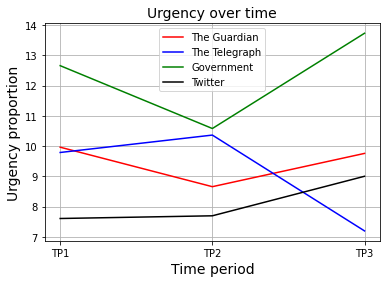

In [168]:
import matplotlib
plt.plot(results_df['Time'], results_df['The Guardian'], color='red', label= 'The Guardian')
plt.plot(results_df['Time'], results_df['The Telegraph'], color='blue', label= 'The Telegraph')
plt.plot(results_df['Time'], results_df['Government'], color='green', label= 'Government')
plt.plot(results_df['Time'], results_df['Twitter'], color='black', label= 'Twitter')
plt.title('Urgency over time', fontsize=14)
plt.xlabel('Time period', fontsize=14)
plt.ylabel('Urgency proportion', fontsize=14)
plt.grid(True)
plt.legend(loc='best')
plt.show()

<b>This is just to export data into something that can be graphed in R</b>

In [ ]:
#create dictionaries for every time period
tp1list = [gtp1_dic,tetp1_dic,of1_dic,twtp1_dic]
tp2list = [gtp2_dic,tetp2_dic,of2_dic,twtp2_dic]
tp3list = [gtp3_dic,tetp3_dic,of3_dic,twtp3_dic]
tp1 = {}
tp2 = {}
tp3 = {}
for i in range(len(tp1list)):
    tp1[i]=urgprop(tp1list[i], 0.4)
for i in range(len(tp2list)):
    tp2[i]=urgprop(tp2list[i], 0.4)
for i in range(len(tp3list)):
    tp3[i]=urgprop(tp3list[i], 0.4)

In [ ]:
#create dataframes
dfexport1 = pd.DataFrame(index=np.arange(1000))
dfexport2 = pd.DataFrame(index=np.arange(1000))
dfexport3 = pd.DataFrame(index=np.arange(1000))

In [ ]:
#dynamically populate dataframes with dictionary data
dfexport1['The Guardian']= pd.Series(tp1[0])
dfexport1['The Telegraph'] = pd.Series(tp1[1])
dfexport1['Official communication'] = pd.Series(tp1[2])
dfexport1['Twitter'] = pd.Series(tp1[3])
dfexport2['The Guardian'] = pd.Series(tp2[0])
dfexport2['The Telegraph'] = pd.Series(tp2[1])
dfexport2['Official communication']= pd.Series(tp2[2])
dfexport2['Twitter']= pd.Series(tp2[3])
dfexport3['The Guardian']= pd.Series(tp3[0])
dfexport3['The Telegraph']= pd.Series(tp3[1])
dfexport3['Official communication']= pd.Series(tp3[2])
dfexport3['Twitter']= pd.Series(tp3[3])

In [ ]:
#export dataframes
dfexport1.to_csv('./exporttp1.csv')
dfexport2.to_csv('./exporttp2.csv')
dfexport3.to_csv('./exporttp3.csv')